# Section 4: **Exploring Factors Influencing Move Quality**

In [123]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pyarrow.parquet as pq

print("Libraries successfully imported")

Libraries successfully imported


In [124]:
# Configuration
DATASET_DIR = Path(r"E:\EDA_chess_data\processed")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)  # Ignore userwarnings from seaborn / matplotlib

# Plotting Style
plt.style.use("seaborn-v0_8-whitegrid")
plot_palette = "viridis"
plot_palette_diverging = "coolwarm"
errorbar_style = ("ci", 95)

# Analysis Constants
CPLOSS_CLIP_FOR_AVG = 1000  # Clip CPLoss at this value when calculating average to reduce outlier impact
BLUNDER_THRESHOLD_CP = 300  # Centipawn loss threshold for a big blunder
TIME_SPENT_QUANTILE_FILTER = 0.99  # Filter out top 1% of time spent per move as outliers
TIME_SPENT_MIN = 0.1  # Minimum time spent to consider (ignores near 0 times)

# ELO bins
elo_bins = [500, 1200, 1900, 2300, np.inf]
elo_labels = ['Beginner (500-1200)', 'Intermediate (1200-1900)', 'Advanced (1900-2300)', 'Expert (2300+)']
tight_bin_width = 100
tight_elo_bins = np.arange(500, 2800 + tight_bin_width, tight_bin_width)
tight_elo_labels = [f'{tight_elo_bins[i]}-{tight_elo_bins[i+1]}' for i in range(len(tight_elo_bins)-2)] + [f'{tight_elo_bins[-2]}+']

print("Configuration and constants set up successfully")

Configuration and constants set up successfully


In [125]:
# Load Data
# Reduce numerical precision when possible
def reduce_memory_usage(df):
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    # Convert relevant object columns expected to be categories
    for col in ['PlayerColor', 'GamePhase', 'TimeControl', 'Termination', 'Result', 'ECO']:
        if col in df.columns:
            df
    return df

try: 
    # Define columns essential for move quality analysis + context
    columns_to_load = [
        'GameID', 'WhiteElo', 'BlackElo', 'TimeControl', 'Ply', 'PlayerColor', 'PlayerELO', 
        'OpponentELO', 'ClockTimeBeforeMoveSec', 'EvaluationBeforeMove', 'MaterialBalanceAbs',
        'PlayerMaterialBalance', 'NumLegalMoves', 'IsCheck_BeforeMove', 'GamePhase', 
        'IsCapture', 'IsCastling', 'TimeSpentSec', 'PlayerRelativeEvalChange'
    ]

    # Load the data
    df_moves_raw = pd.read_parquet(DATASET_DIR, columns=columns_to_load, engine='pyarrow')

    # Reduce memory usage
    df_moves = reduce_memory_usage(df_moves_raw.copy())

    print(f"Loaded {len(df_moves)} moves.")
    print("Initial memory usage:", df_moves.memory_usage(deep=True).sum() / 1024**2, "MB")
    print("\nColumns loaded and types:")
    print(df_moves.info())
    
    
except FileNotFoundError:
    print(f"ERROR: Dataset directory not fouund at {DATASET_DIR}.")
    df_moves = pd.DataFrame() # Create empty df to avoid later error when running all cells

except Exception as e:
    print(f"ERROR: An unexpected error occurred: {e}")
    df_moves = pd.DataFrame()

print("Show first 5 samples of each feature")
print(df_moves.head())

# # Analyze feature Eval related features
# print(f"Percentage of nan values in 'EvaluationBeforeMove': {df_moves['EvaluationBeforeMove'].isna().mean() * 100:.2f}%")
# print(f"Percentage of nan values in 'MaterialBalanceAbs': {df_moves['MaterialBalanceAbs'].isna().mean() * 100:.2f}%")
# print(f"Percentage of nan values in 'PlayerRelativeEvalChange': {df_moves['PlayerRelativeEvalChange'].isna().mean() * 100:.2f}%")

# print(f"First 20 samples of 'EvaluationBeforeMove':")
# print(df_moves['EvaluationBeforeMove'].head(20))

# print(f"First 20 samples of 'MaterialBalanceAbs':")
# print(df_moves['MaterialBalanceAbs'].head(20))

# print(f"First 20 samples of 'PlayerMaterialBalance':")
# print(df_moves['PlayerMaterialBalance'].head(20))

# Show non-null values in 'PlayerRelativeEvalChange' and 'EvaluationBeforeMove'
print(f"First 20 non-nan samples of 'PlayerRelativeEvalChange':")
print(df_moves.loc[df_moves['PlayerRelativeEvalChange'].notna(), 'PlayerRelativeEvalChange'].head(20))
print(f"First 20 non-nan samples of 'EvaluationBeforeMove':")
print(df_moves.loc[df_moves['EvaluationBeforeMove'].notna(), 'EvaluationBeforeMove'].head(20))

Loaded 10593734 moves.
Initial memory usage: 2769.085364341736 MB

Columns loaded and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10593734 entries, 0 to 10593733
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   GameID                    object 
 1   WhiteElo                  int16  
 2   BlackElo                  int16  
 3   TimeControl               object 
 4   Ply                       int16  
 5   PlayerColor               object 
 6   PlayerELO                 int16  
 7   OpponentELO               int16  
 8   ClockTimeBeforeMoveSec    float32
 9   EvaluationBeforeMove      float32
 10  MaterialBalanceAbs        int8   
 11  PlayerMaterialBalance     int8   
 12  NumLegalMoves             int8   
 13  IsCheck_BeforeMove        bool   
 14  GamePhase                 object 
 15  IsCapture                 bool   
 16  IsCastling                bool   
 17  TimeSpentSec              float32
 18  PlayerR

In [126]:
# Basic Data Cleaning and Feature Engineering
if not df_moves.empty:
    # 1. Calculate CPLoss in centipawns
    df_moves['CPLoss'] = (-df_moves['PlayerRelativeEvalChange'] * 100).clip(lower=0)

    # 2. Identify Big Blunders
    df_moves['IsBigBlunder'] = (df_moves['CPLoss'].fillna(0) > BLUNDER_THRESHOLD_CP).astype(int)

    # 3. Add ELO bins (based on PlayerELO for move analysis)
    df_moves.dropna(subset=['PlayerELO'], inplace=True)  # Drop rows with NaN PlayerELO
    df_moves['PlayerELO'] = df_moves['PlayerELO'].astype(int)  # Ensure PlayerELO is int for binning
    df_moves['EloBin'] = pd.cut(df_moves['PlayerELO'], bins=elo_bins, labels=elo_labels, right=False)
    df_moves['EloBinTight'] = pd.cut(df_moves['PlayerELO'], bins=tight_elo_bins, labels=tight_elo_labels, right=False)

    # 4. Handle Time Spent Outliers
    time_spent_upper_limit = df_moves['TimeSpentSec'].quantile(TIME_SPENT_QUANTILE_FILTER)
    print(f"Filtering TimeSpentSec: Keeping > {TIME_SPENT_MIN} and <= {time_spent_upper_limit} (based on {TIME_SPENT_QUANTILE_FILTER} quantile)")
    df_moves_filtered_time = df_moves[
        (df_moves['TimeSpentSec'] > TIME_SPENT_MIN) & 
        (df_moves['TimeSpentSec'] <= time_spent_upper_limit)
    ].copy()

    # 5. Bin Continuous Predictors (using the time-filtered df where appropriate)
    # Bin Time Spent (on the filtered data)
    time_bins = [-np.inf, 1, 3, 5, 10, 20, 30, 60, 120, np.inf]
    time_labels = ['<1s', '1-3s', '3-5s', '5-10s', '10-20s', '20-30s', '30-60s', '1-2m', '>2m']
    df_moves_filtered_time['TimeSpentBin'] = pd.cut(df_moves_filtered_time['TimeSpentSec'], bins=time_bins, labels=time_labels, right=False)

    # Bin Clock Time Remaining
    clock_bins = [-np.inf, 5, 10, 30, 60, 120, 300, np.inf]  # In seconds
    clock_labels = ['<5s', '5-10s', '10-30s', '30-60s', '1-2m', '2-5m', '>5m']
    df_moves['ClockTimeBin'] = pd.cut(df_moves['ClockTimeBeforeMoveSec'], bins=clock_bins, labels=clock_labels, right=False)
    # Add to filtered df as well
    df_moves_filtered_time['ClockTimeBin'] = pd.cut(df_moves_filtered_time['ClockTimeBeforeMoveSec'], bins=clock_bins, labels=clock_labels, right=False)

    # Bin Ply (Move Number)
    ply_bins = [0, 10, 20, 30, 40, 50, 60, 80, 100, np.inf]
    ply_labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-80', '81-100', '>100']
    df_moves['PlyBin'] = pd.cut(df_moves['Ply'], bins=ply_bins, labels=ply_labels, right=False)
    # Add to filtered df as well
    df_moves_filtered_time['PlyBin'] = pd.cut(df_moves_filtered_time['Ply'], bins=ply_bins, labels=ply_labels, right=False)

    # Bin Number of Legal Moves
    legal_move_bins = [0, 1, 2, 3, 5, 10, 20, 30, 40, np.inf]
    legal_move_labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21-30', '31-40', '>40']
    df_moves['LegalMovesBin'] = pd.cut(df_moves['NumLegalMoves'], bins=legal_move_bins, labels=legal_move_labels, right=False)
    # Add to filtered df as well
    df_moves_filtered_time['LegalMovesBin'] = pd.cut(df_moves_filtered_time['NumLegalMoves'], bins=legal_move_bins, labels=legal_move_labels, right=False)

    # Bin Player Material Balance (relative to opponent)
    mat_bins = [-np.inf, -10, -5, -3, -2, -1, 0, 1, 2, 3, 5, 10, np.inf]
    mat_labels = ['<-10', '-10 to -5', '-5 to -3', '-3 to -2', '-2 to -1', '-1 to 0', '0 to 1', '1 to 2', '2 to 3', '3 to 5', '5 to 10', '>10']
    if 'PlayerMaterialBalance' in df_moves.columns:
        df_moves['PlayerMaterialBalanceBin'] = pd.cut(df_moves['PlayerMaterialBalance'], bins=mat_bins, labels=mat_labels, right=False)
        # Add to filtered df as well
        df_moves_filtered_time['PlayerMaterialBalanceBin'] = pd.cut(df_moves_filtered_time['PlayerMaterialBalance'], bins=mat_bins, labels=mat_labels, right=False)
    else: print("WARNING: 'PlayerMaterialBalance' column not found for binning.")

    # Bin Evaluation Before Move
    eval_bins = [-np.inf, -1000, -500, -300, -200, -100, 0, 100, 200, 300, 500, 1000, np.inf]
    eval_labels = ['<-1000', '-1000 to -500', '-500 to -300', '-300 to -200', '-200 to -100', '-100 to 0', '0 to 100', '100 to 200', '200 to 300', '300 to 500', '500 to 1000', '>1000']
    if 'EvaluationBeforeMove' in df_moves.columns:
        df_moves['EvalBeforeMoveCP'] = df_moves['EvaluationBeforeMove'] * 100
        df_moves['EvalBin'] = pd.cut(df_moves['EvalBeforeMoveCP'], bins=eval_bins, labels=eval_labels, right=False)
        # Add to filtered df as well
        df_moves_filtered_time['EvalBeforeMoveCP'] = df_moves_filtered_time['EvaluationBeforeMove'] * 100
        df_moves_filtered_time['EvalBin'] = pd.cut(df_moves_filtered_time['EvalBeforeMoveCP'], bins=eval_bins, labels=eval_labels, right=False)
    else: print("WARNING: 'EvaluationBeforeMove' column not found for binning.")

    # 6. Handle GamePhase
    if df_moves['GamePhase'].dtype != 'category':
        df_moves['GamePhase'] = df_moves['GamePhase'].astype('category')
        df_moves_filtered_time['GamePhase'] = df_moves_filtered_time['GamePhase'].astype('category')

    print("\nPreprocessing and Feature Engineering Complete.")
    print("Memory usage after processing:", df_moves.memory_usage(deep=True).sum() / 1024**2, "MB")
    print("Memory usage of time_filtered df:", df_moves_filtered_time.memory_usage(deep=True).sum() / 1024**2, "MB")

else:
    print("Skipping preprocessing as data failed to load.")
    df_moves_filtered_time = pd.DataFrame()  # Create empty df to avoid later error when running all cells

# # Inspect CPLoss 
# print(f"\nFirst 100 samples of CPLoss:")
# print(df_moves['CPLoss'].head(20))

# print(f"Total CPLoss values: {df_moves['CPLoss'].count()} (excluding NaNs)")
# print(f"Total NaN CPLoss values: {df_moves['CPLoss'].isnull().sum()}")
# print(f"Total Big Blunders (1): {df_moves['IsBigBlunder'].sum()}")
# print(f"Moves not counted as Big Blunders (0): {(df_moves['IsBigBlunder'] == 0).sum()}")

Filtering TimeSpentSec: Keeping > 0.1 and <= 33.0 (based on 0.99 quantile)

Preprocessing and Feature Engineering Complete.
Memory usage after processing: 2492.53235912323 MB
Memory usage of time_filtered df: 1962.0125713348389 MB



--- Analysis 1: Correlation Heatmap ---


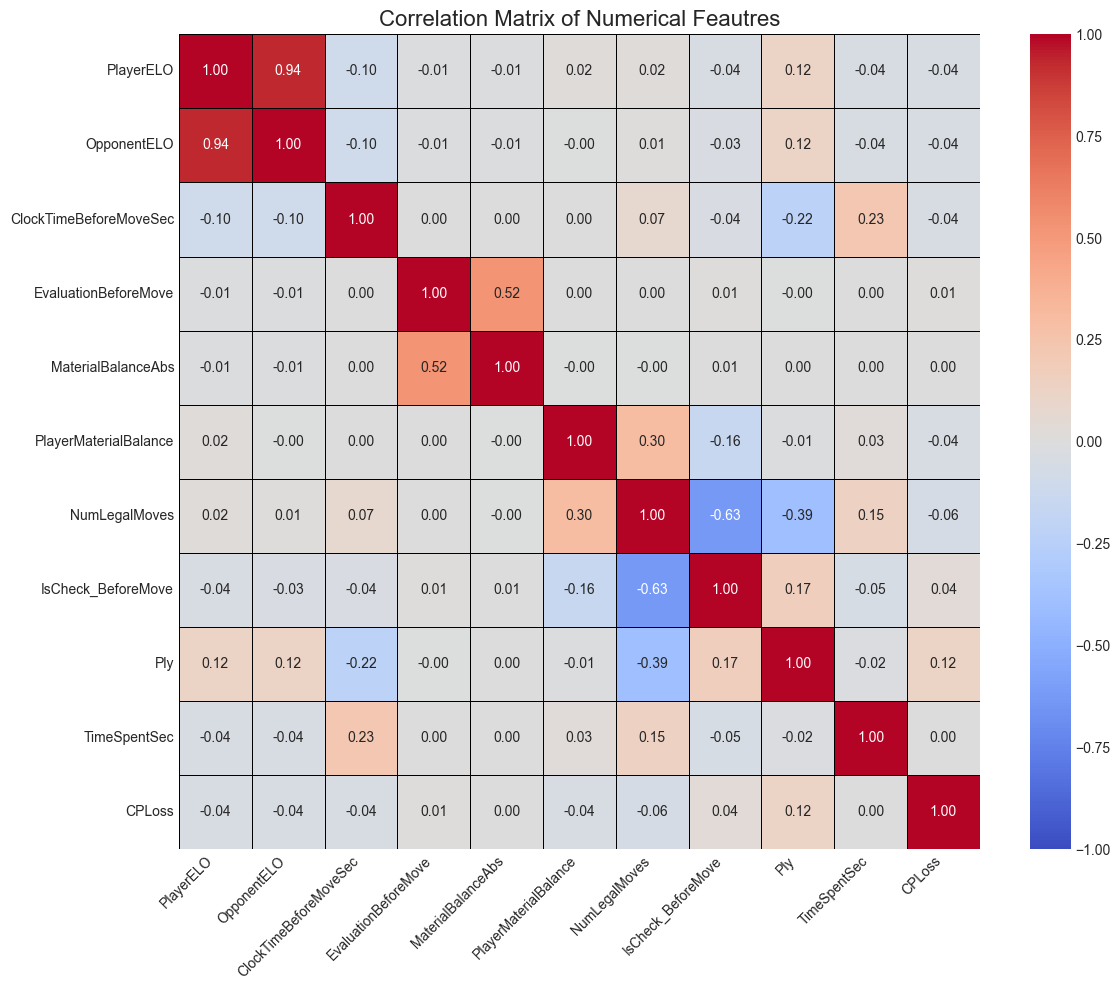

In [127]:
# Analysis 1 - Correlation Heatmap

if not df_moves.empty:
    print("\n--- Analysis 1: Correlation Heatmap ---")
    # Select numerical features of interest (use original df_moves for borader view)
    numerical_cols = [
        'PlayerELO', 'OpponentELO', 'ClockTimeBeforeMoveSec', 'EvaluationBeforeMove',
        'MaterialBalanceAbs', 'PlayerMaterialBalance', 'NumLegalMoves', 'IsCheck_BeforeMove',
        'Ply', 'TimeSpentSec', 'CPLoss' # Target variable
    ]
    # Filter out columns that might not exist
    numerical_cols = [col for col in numerical_cols if col in df_moves.columns]

    if len(numerical_cols) > 1:
        # Drop rows with NaNs in these specific columns for correlation calculation
        corr_df = df_moves[numerical_cols].dropna()

        # Limit CPLoss for correlation calculation to reduce outlier skewness? 
        # corr_df['CPLoss'] = corr_df['CPLoss'].clip(upper=CPLOSS_CLIP_FOR_AVG)

        correlation_matrix = corr_df.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap=plot_palette_diverging, fmt=".2f", 
                    linewidths=0.5, linecolor='black', vmin=-1, vmax=1)
        plt.title("Correlation Matrix of Numerical Feautres", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping heatmap - Not enough numerical columns found.")
else:
    print("Skipping heatmap - Data failed to load.")


--- Analysis 2: Average CPLoss vs. Key Factors ---


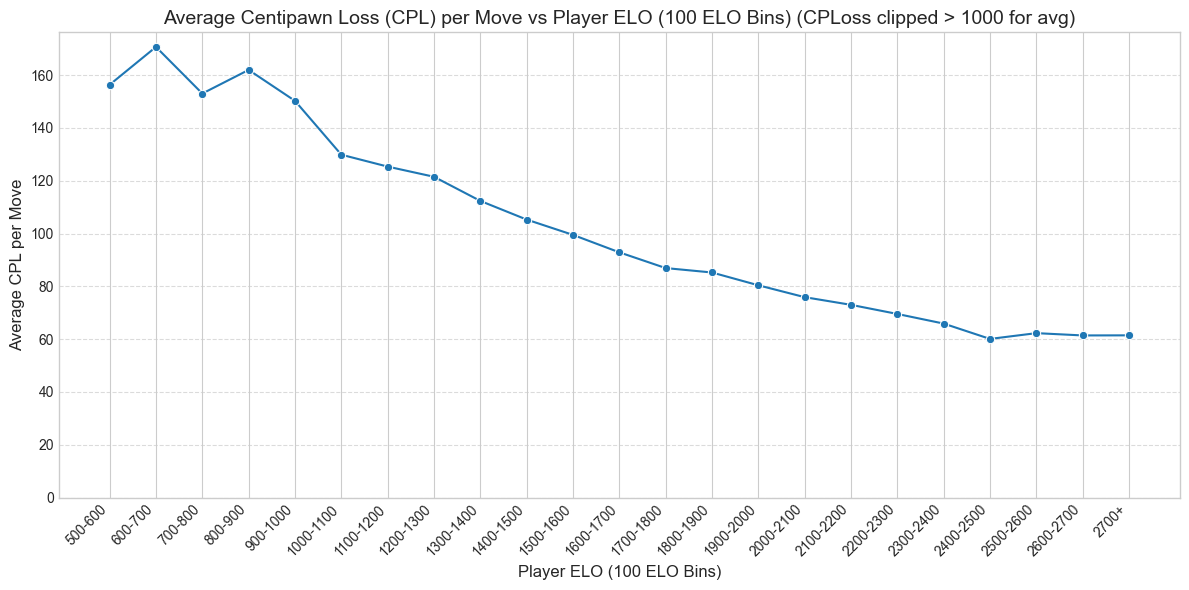

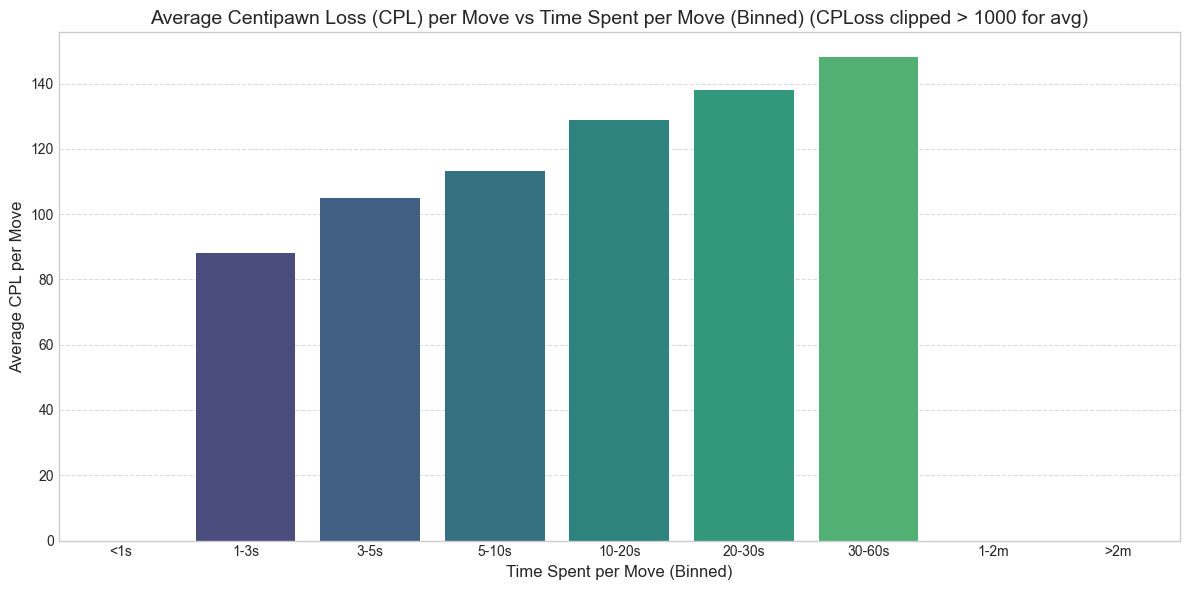

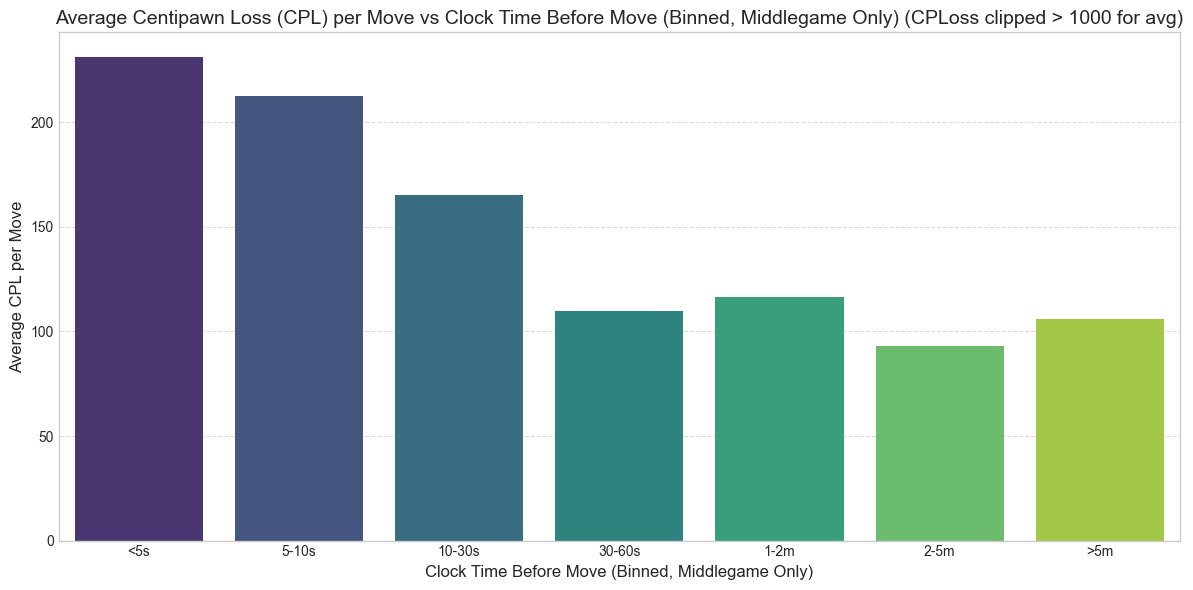

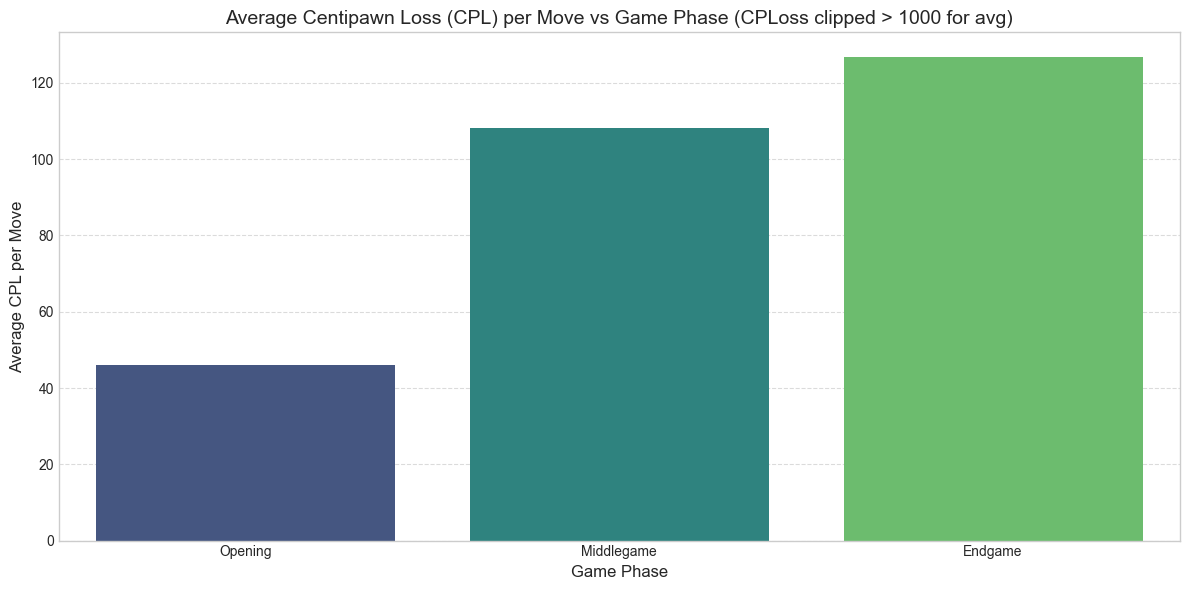

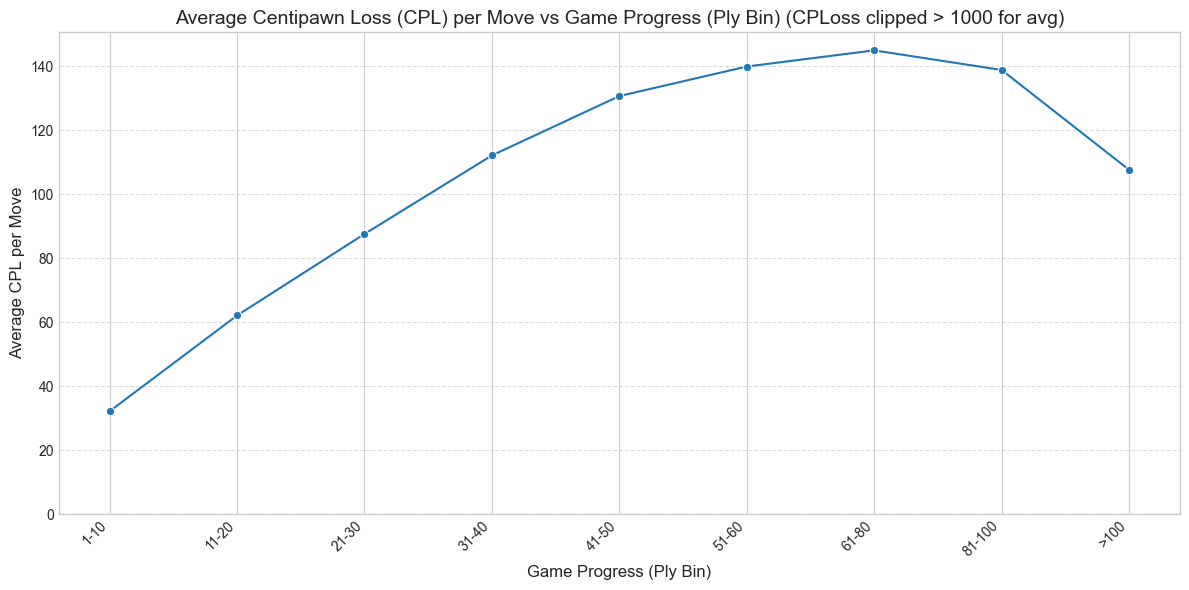

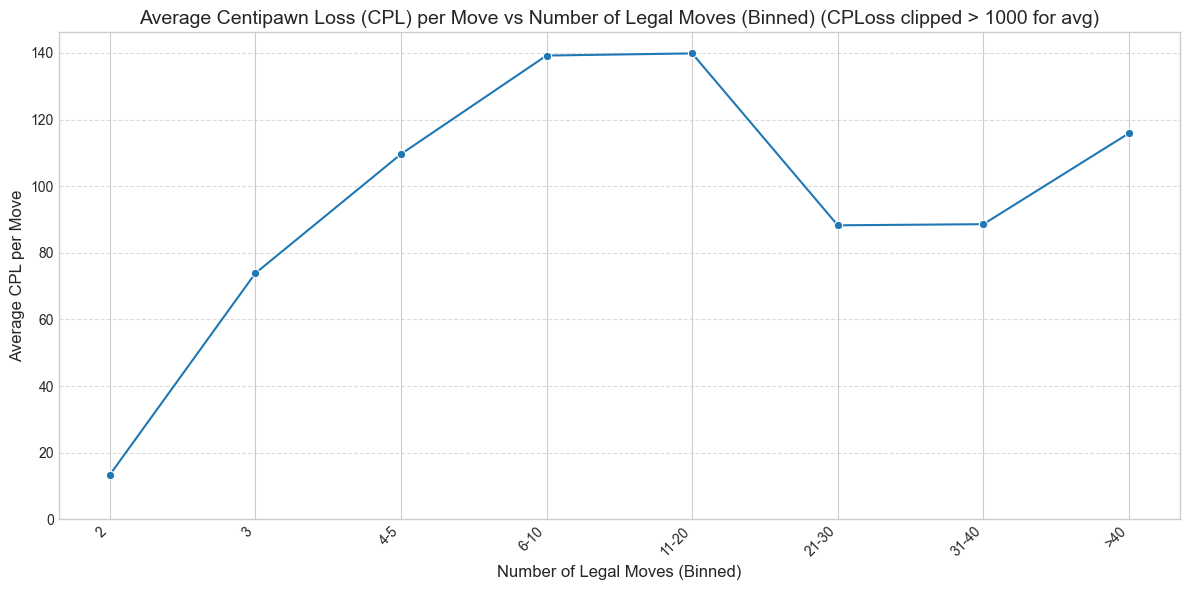

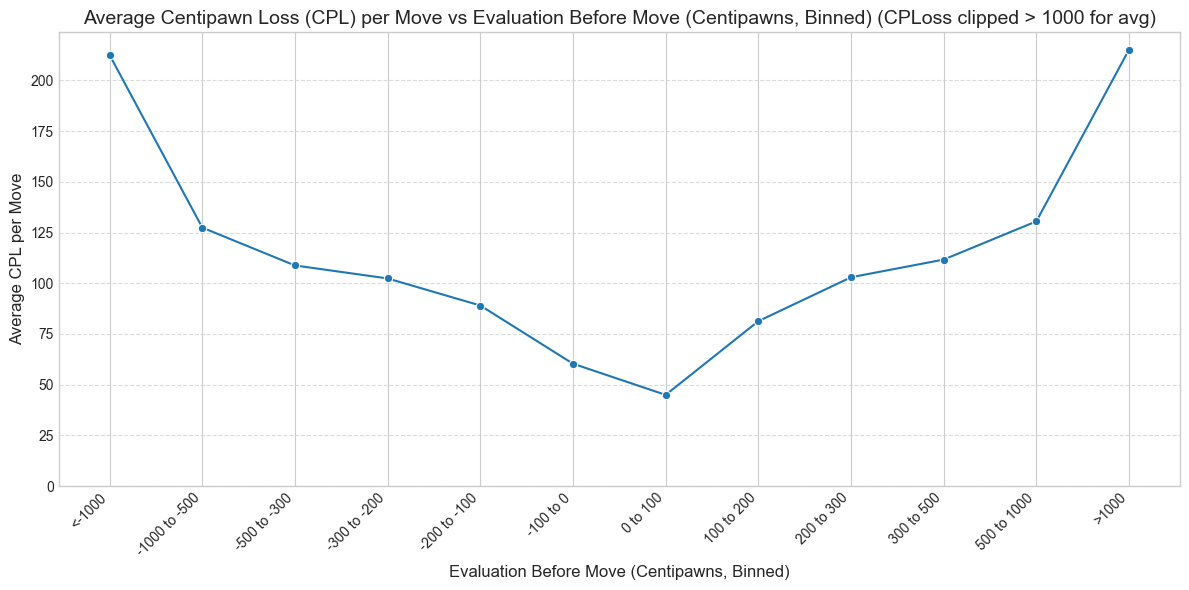

In [128]:
# Analysis 2 - Average CPLoss vs Key Factors

if not df_moves.empty:
    print("\n--- Analysis 2: Average CPLoss vs. Key Factors ---")
    # Define a function to plot Avg CPL vs a factor
    def plot_avg_cpl(df, factor_col, factor_label, plot_type='line', filter_cpl=True, **kwargs):
        if factor_col not in df.columns:
            print(f"Skipping plot: Column '{factor_col}' not found.")
            return

        # Drop rows where the factor or CPLoss is NaN
        plot_data = df.dropna(subset=[factor_col, 'CPLoss'])

        if filter_cpl:
            # Apply clipping before calculating mean
            agg_data = plot_data.groupby(factor_col, observed=False).agg(
                Avg_CPLoss=('CPLoss', lambda x: x.clip(upper=CPLOSS_CLIP_FOR_AVG).mean()),
                MoveCount=('CPLoss', 'count') # Get count for context
            ).reset_index()
            title_suffix = f' (CPLoss clipped > {CPLOSS_CLIP_FOR_AVG} for avg)'
        else:
            agg_data = plot_data.groupby(factor_col, observed=False).agg(
                Avg_CPLoss=('CPLoss', 'mean'),
                 MoveCount=('CPLoss', 'count')
            ).reset_index()
            title_suffix = ''

        # Filter out bins with very few moves if desired
        # agg_data = agg_data[agg_data['MoveCount'] > 50]

        if agg_data.empty:
            print(f"Skipping plot for {factor_label}: No data after aggregation.")
            return

        plt.figure(figsize=(12, 6))
        if plot_type == 'line':
            sns.lineplot(data=agg_data, x=factor_col, y='Avg_CPLoss', marker='o', **kwargs)
            plt.xticks(rotation=45, ha='right')
        elif plot_type == 'bar':
            sns.barplot(data=agg_data, x=factor_col, y='Avg_CPLoss', palette=plot_palette, **kwargs)
            plt.xticks(rotation=0) # Bars usually don't need rotation unless many categories

        plt.title(f'Average Centipawn Loss (CPL) per Move vs {factor_label}{title_suffix}', fontsize=14)
        plt.xlabel(factor_label, fontsize=12)
        plt.ylabel('Average CPL per Move', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.ylim(bottom=0) # CPLoss is non-negative
        plt.tight_layout()
        plt.show()

    # --- Generate Plots ---
    # vs. Player ELO (Tight Bins)
    plot_avg_cpl(df_moves, 'EloBinTight', 'Player ELO (100 ELO Bins)')

    # vs. Time Spent (Binned, use filtered df)
    plot_avg_cpl(df_moves_filtered_time, 'TimeSpentBin', 'Time Spent per Move (Binned)', plot_type='bar')

    # vs. Remaining Clock Time (Binned) - FILTERED FOR MIDDLEGAME
    # Ensure GamePhase column exists and filter for Middlegame
    if 'GamePhase' in df_moves.columns:
        df_moves_middlegame = df_moves[df_moves['GamePhase'] == 'Middlegame'].copy()
        if not df_moves_middlegame.empty and 'ClockTimeBin' in df_moves_middlegame.columns:
             # Now call the plot function with the filtered data
            plot_avg_cpl(df_moves_middlegame,
                         'ClockTimeBin',
                         'Clock Time Before Move (Binned, Middlegame Only)',
                         plot_type='bar')
        elif 'ClockTimeBin' not in df_moves.columns:
             print("Skipping Avg CPLoss vs Clock Time (Middlegame) - 'ClockTimeBin' column missing.")
        else:
            print("Skipping Avg CPLoss vs Clock Time (Middlegame) - No middlegame data found.")
    else:
        print("Skipping Avg CPLoss vs Clock Time (Middlegame) - 'GamePhase' column not found.")

    # vs. Game Phase
    plot_avg_cpl(df_moves, 'GamePhase', 'Game Phase', plot_type='bar', order=['Opening', 'Middlegame', 'Endgame'])

    # vs. Ply (Move Number, Binned)
    plot_avg_cpl(df_moves, 'PlyBin', 'Game Progress (Ply Bin)')

    # vs. Number of Legal Moves (Binned)
    plot_avg_cpl(df_moves, 'LegalMovesBin', 'Number of Legal Moves (Binned)')

    # vs. Material Balance (Binned)
    if 'MaterialBin' in df_moves.columns:
        plot_avg_cpl(df_moves, 'MaterialBin', 'Player Material Balance (Binned)')

    # vs. Evaluation Before Move (Binned)
    if 'EvalBin' in df_moves.columns:
        plot_avg_cpl(df_moves, 'EvalBin', 'Evaluation Before Move (Centipawns, Binned)')

else:
    print("Skipping Analysis 2 - Data not loaded.")


--- Analysis 3: Distribution of CPLoss vs. Key Factors ---


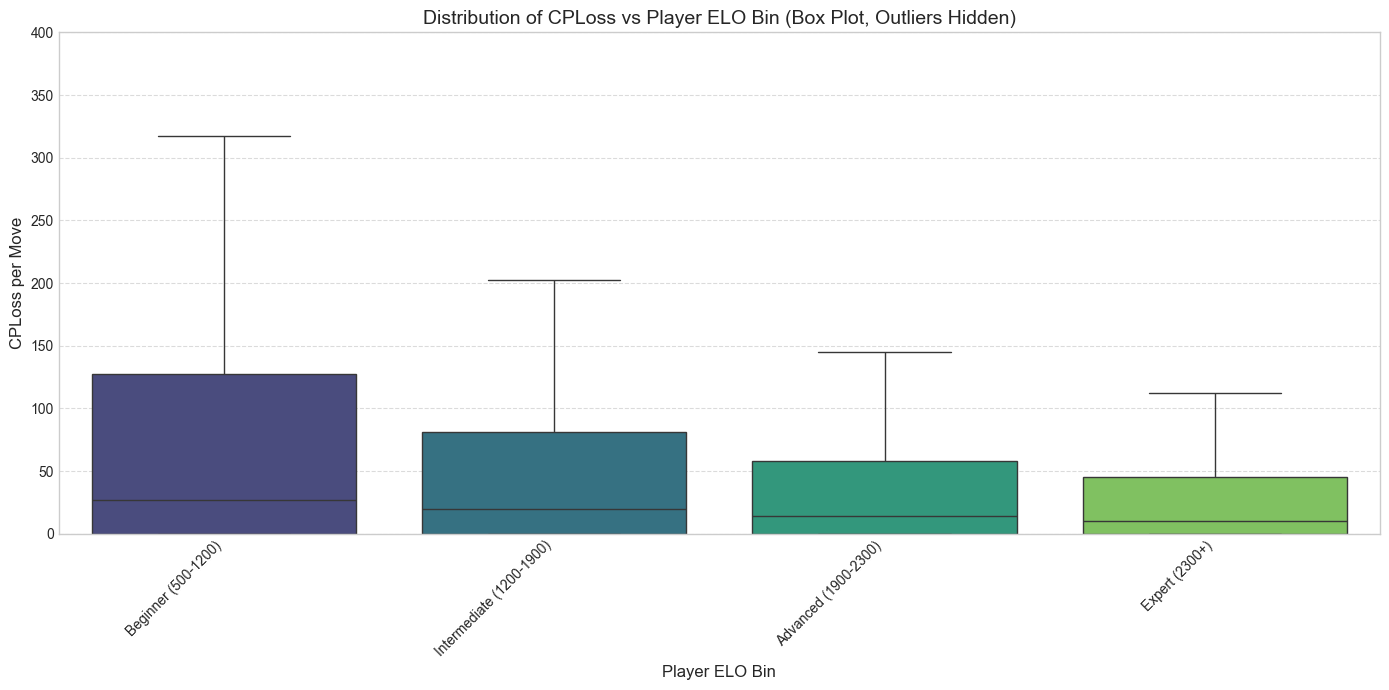

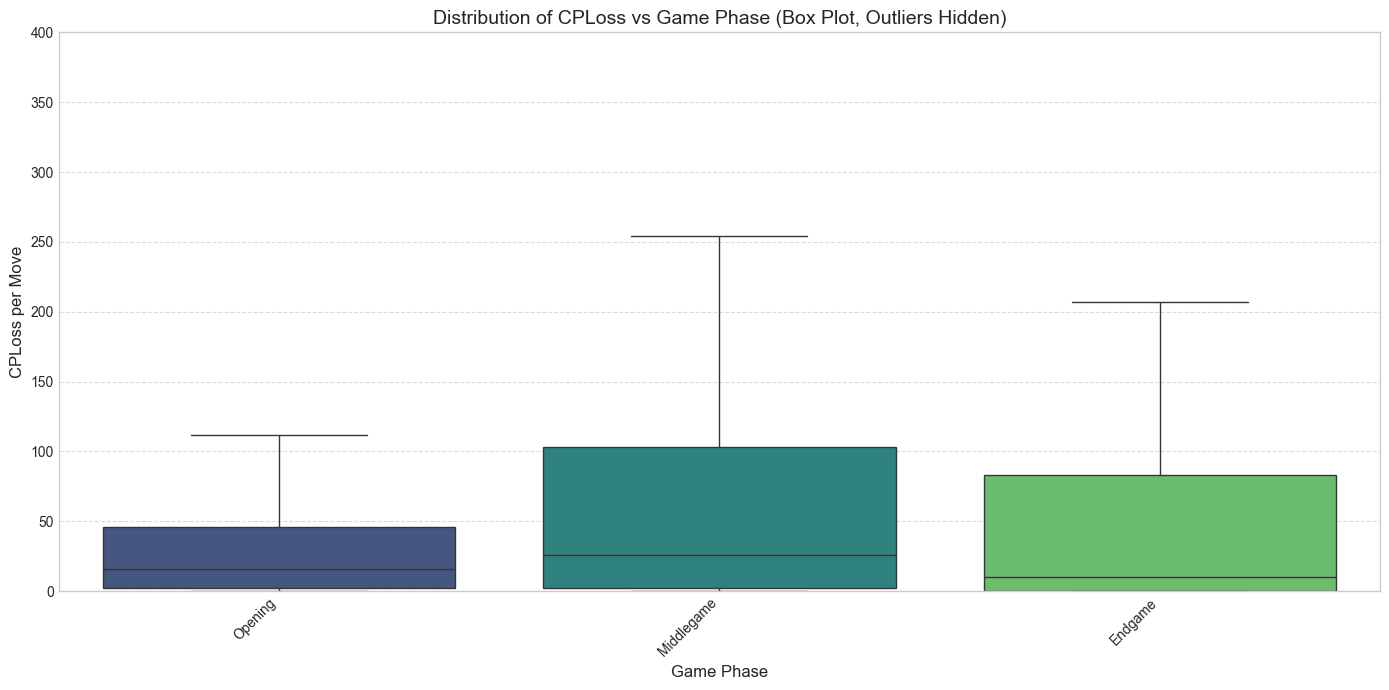

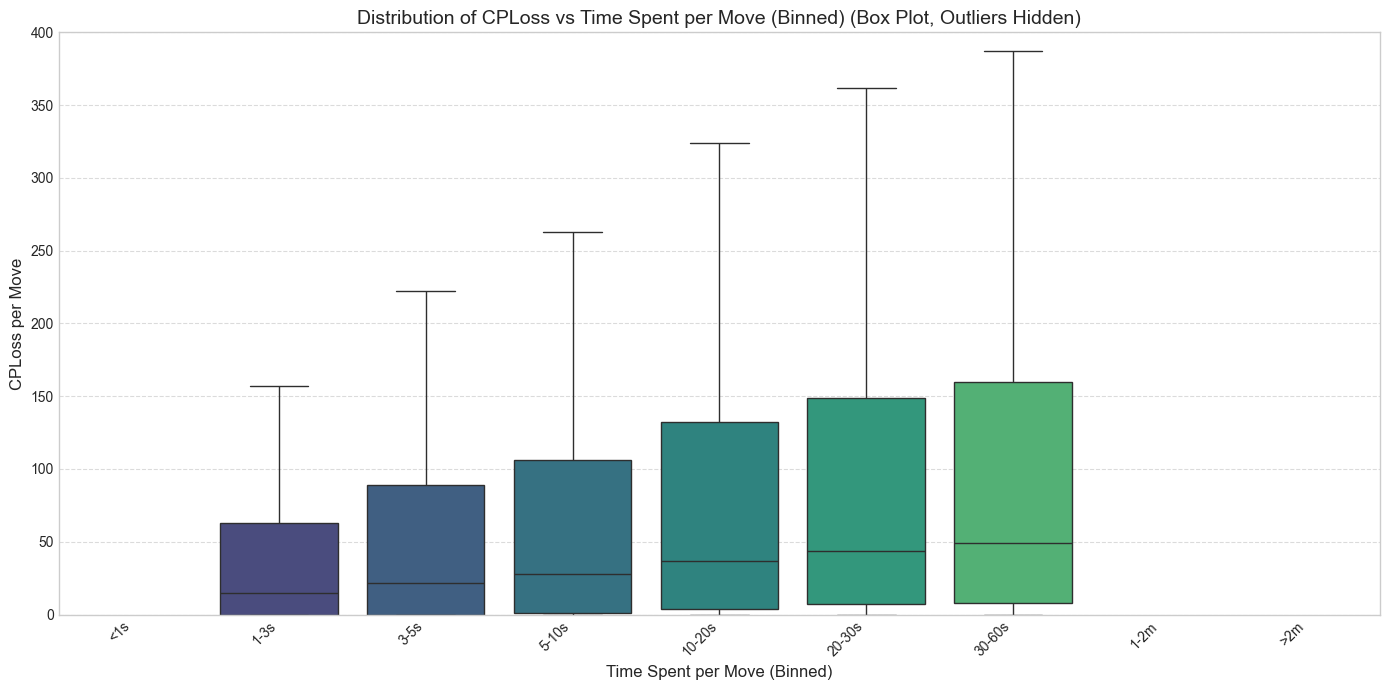

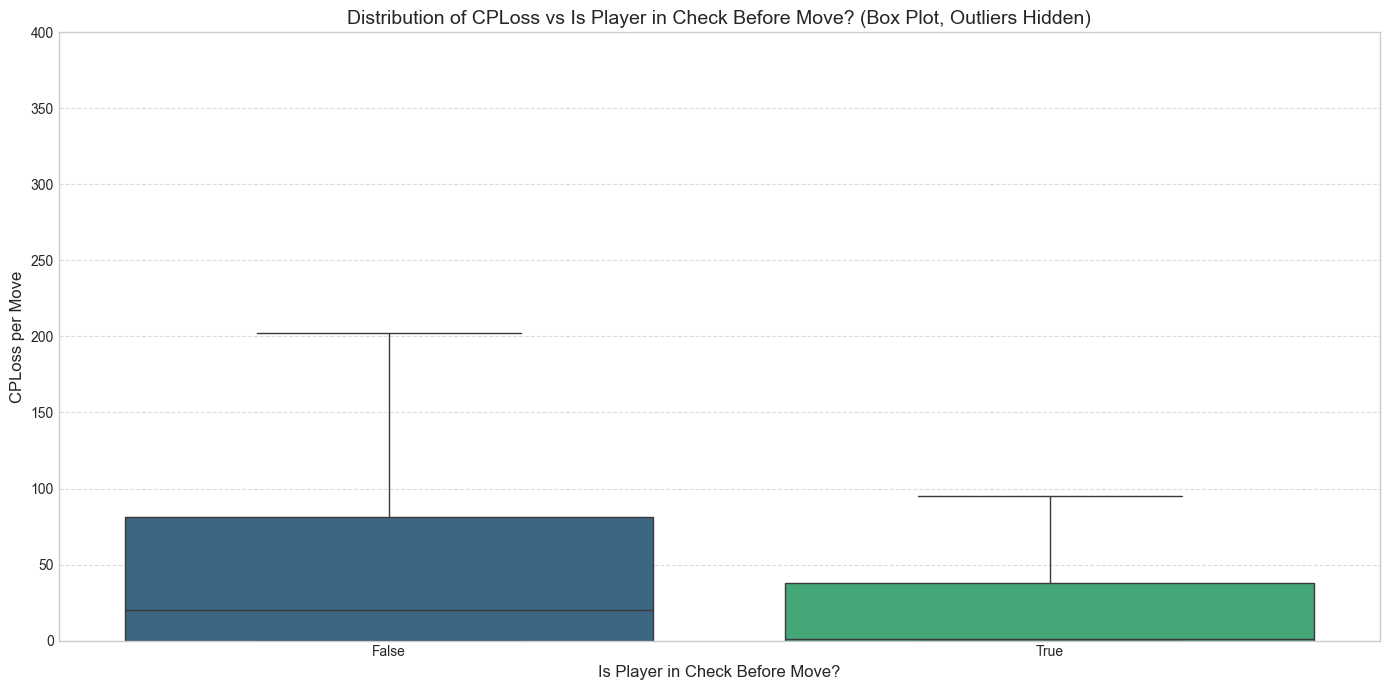

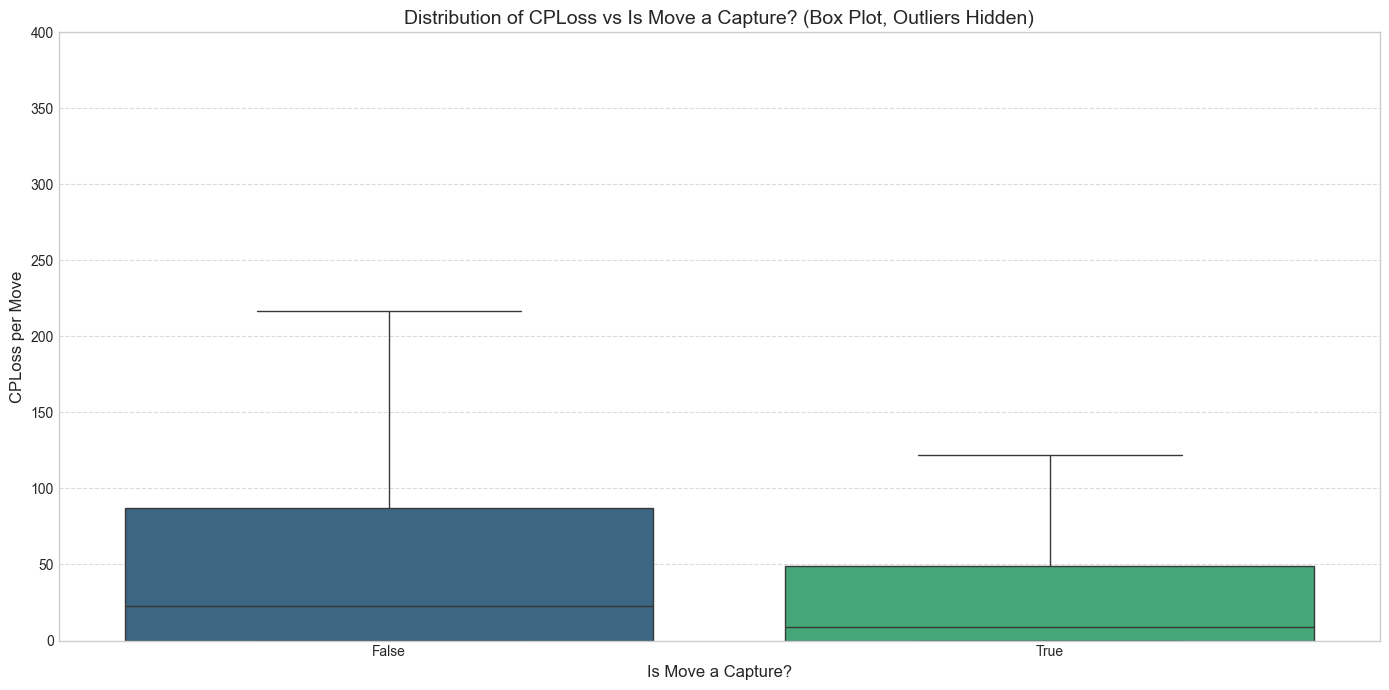

In [129]:
# Analysis 3 - Distribution of CPLoss vs. Key Factors (Box/Violin)

if not df_moves.empty:
    print("\n--- Analysis 3: Distribution of CPLoss vs. Key Factors ---")
    # --- Using Box Plots (Focus on median/quartiles, hide outliers for clarity) ---
    CPLOSS_YLIM_BOX = (0, 400) # Limit Y-axis for CPLoss distribution plots

    def plot_dist_cpl_box(df, factor_col, factor_label, **kwargs):
        if factor_col not in df.columns:
            print(f"Skipping plot: Column '{factor_col}' not found.")
            return

        plt.figure(figsize=(14, 7))
        sns.boxplot(data=df, x=factor_col, y='CPLoss', palette=plot_palette, showfliers=False, **kwargs) # showfliers=False is key
        plt.title(f'Distribution of CPLoss vs {factor_label} (Box Plot, Outliers Hidden)', fontsize=14)
        plt.xlabel(factor_label, fontsize=12)
        plt.ylabel('CPLoss per Move', fontsize=12)
        plt.ylim(CPLOSS_YLIM_BOX) # Apply Y-limit
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if df[factor_col].dtype == 'category' or df[factor_col].nunique() > 10 : # Rotate if categorical or many bins
             plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # --- Generate Plots ---
    # vs. Player ELO (Broad Bins)
    plot_dist_cpl_box(df_moves, 'EloBin', 'Player ELO Bin', order=elo_labels)

    # vs. Game Phase
    plot_dist_cpl_box(df_moves, 'GamePhase', 'Game Phase', order=['Opening', 'Middlegame', 'Endgame'])

    # vs. Time Spent (Binned, use filtered df)
    plot_dist_cpl_box(df_moves_filtered_time, 'TimeSpentBin', 'Time Spent per Move (Binned)')

    # vs. Is Check Before Move
    plot_dist_cpl_box(df_moves, 'IsCheck_BeforeMove', 'Is Player in Check Before Move?')

    # vs. Is Capture
    plot_dist_cpl_box(df_moves, 'IsCapture', 'Is Move a Capture?')

    # Optional: Violin Plot Example (shows density shape)
    # plt.figure(figsize=(14, 7))
    # sns.violinplot(data=df_moves, x='EloBin', y='CPLoss', palette=plot_palette, order=elo_labels, cut=0) # cut=0 limits density to data range
    # plt.title(f'Distribution of CPLoss vs Player ELO Bin (Violin Plot)', fontsize=14)
    # plt.xlabel('Player ELO Bin', fontsize=12)
    # plt.ylabel('CPLoss per Move', fontsize=12)
    # plt.ylim(CPLOSS_YLIM_BOX) # Still need Y-limit
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.tight_layout()
    # plt.show()

else:
    print("Skipping Analysis 3 - Data not loaded.")


--- Analysis 4: Blunder Rate vs. Key Factors ---


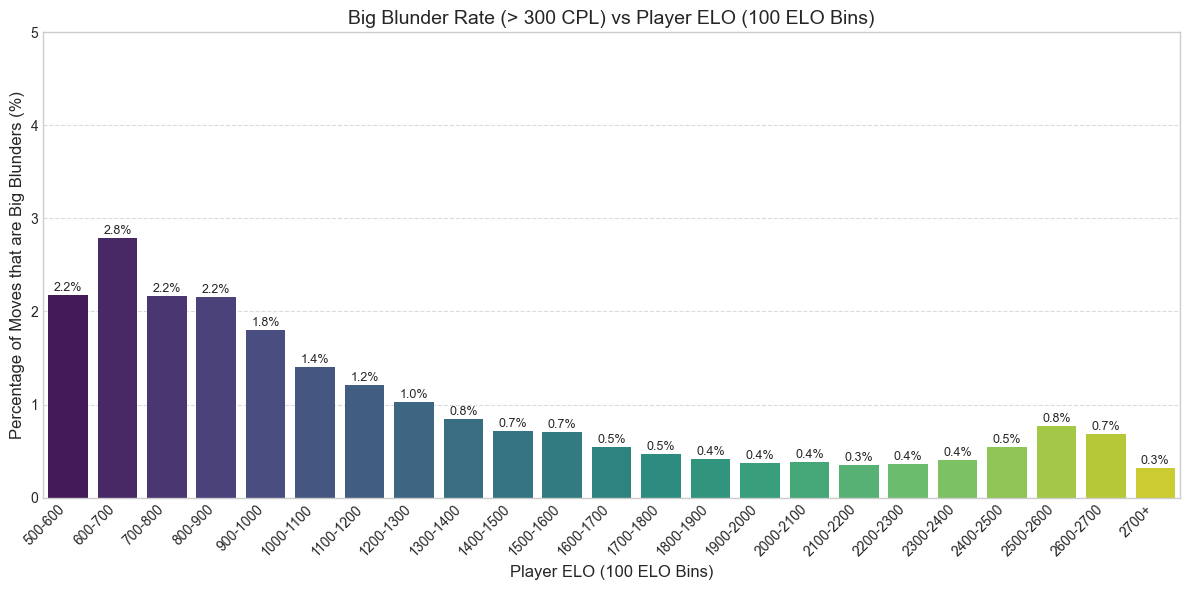

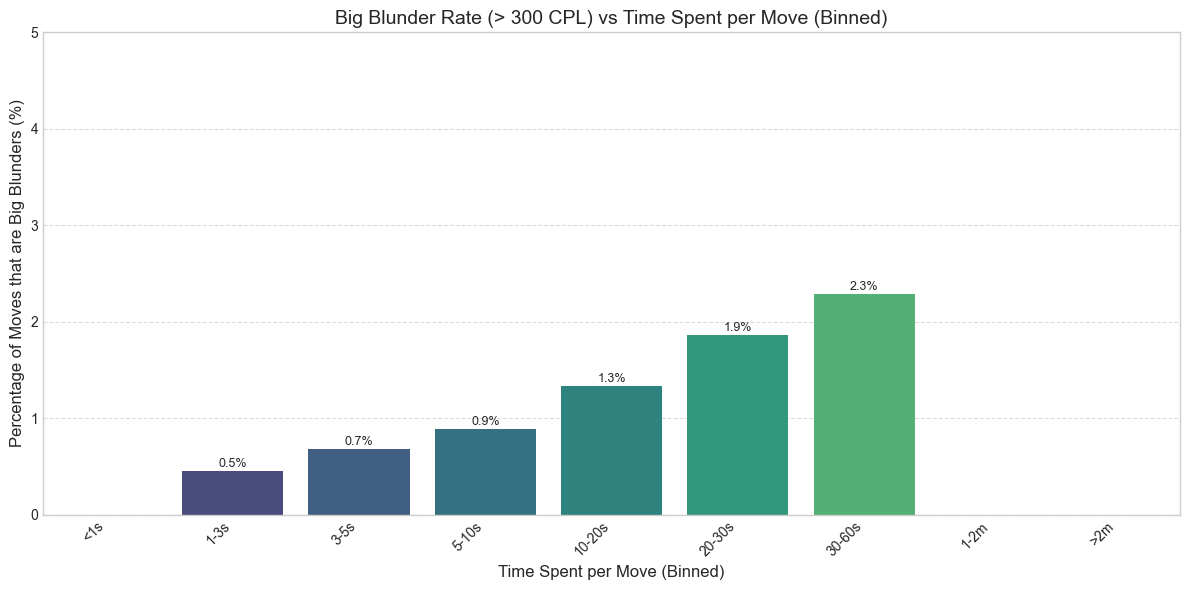


Plotting: Blunder Rate vs Clock Time (Middlegame Only)


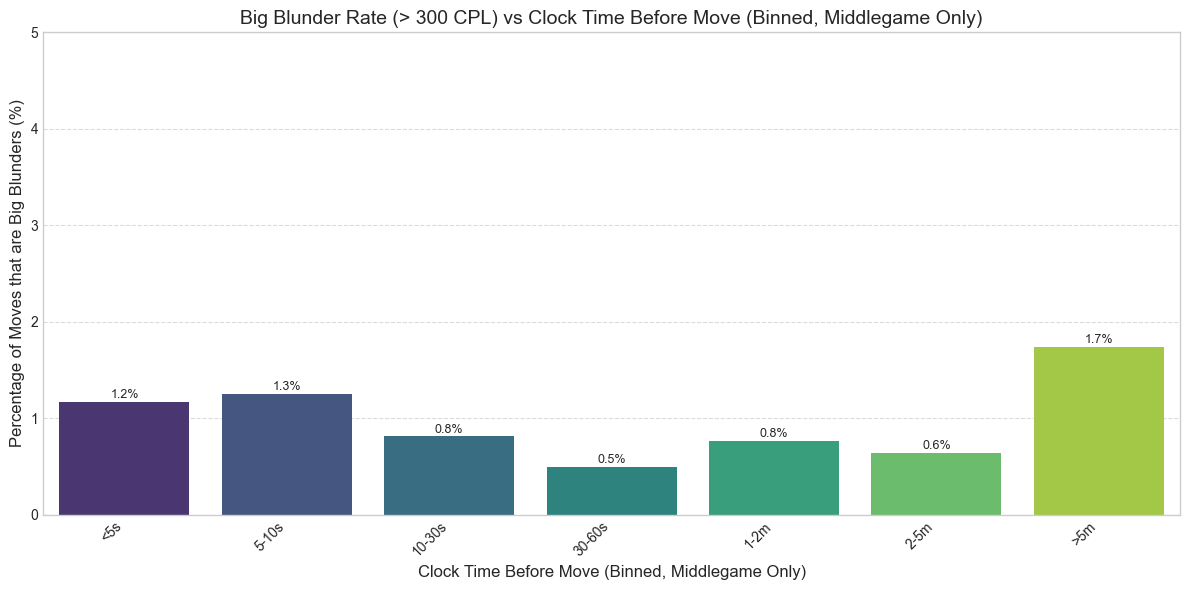

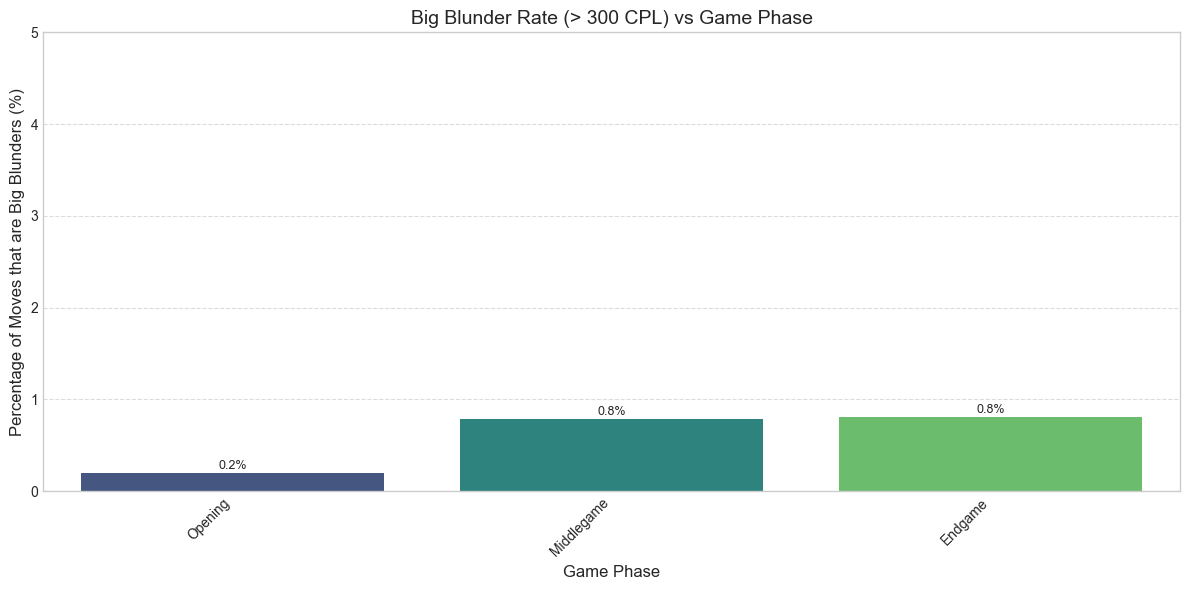

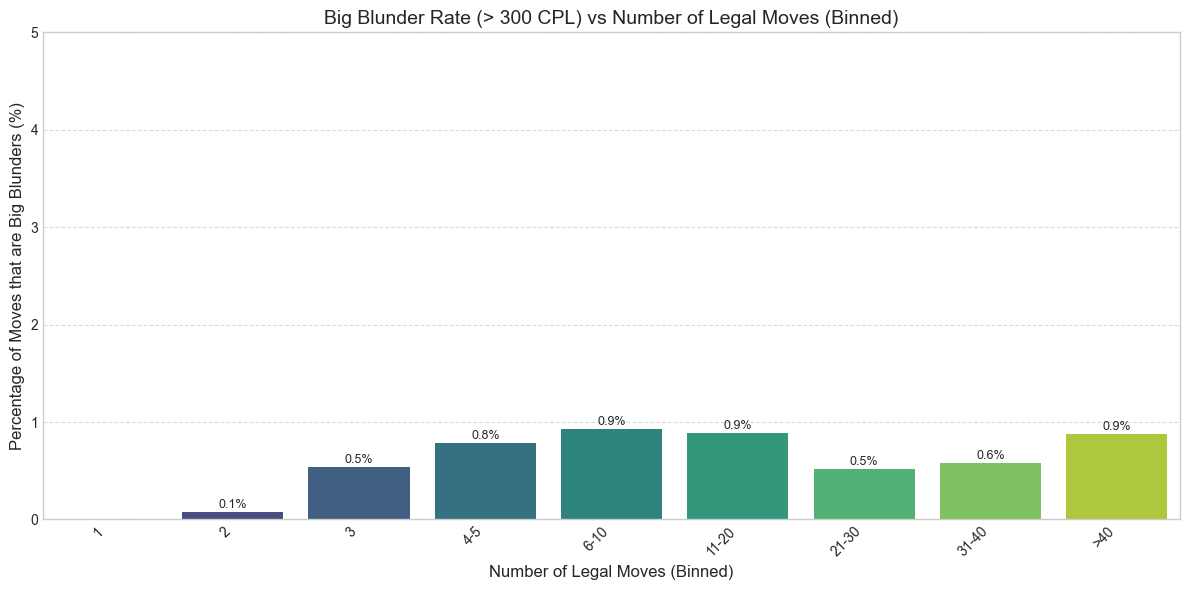

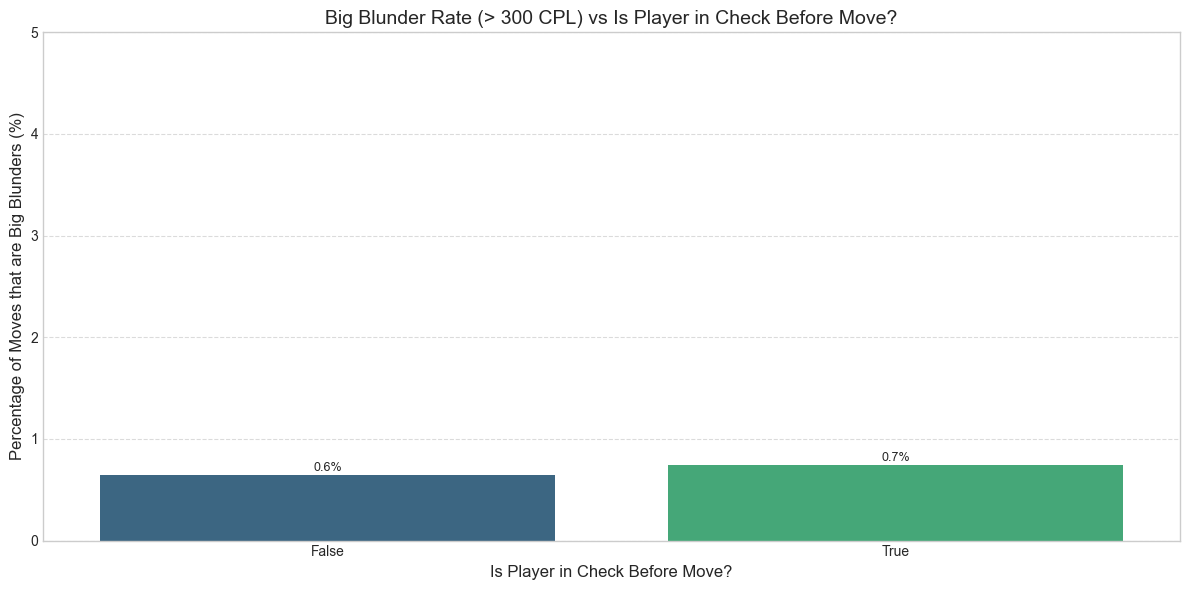

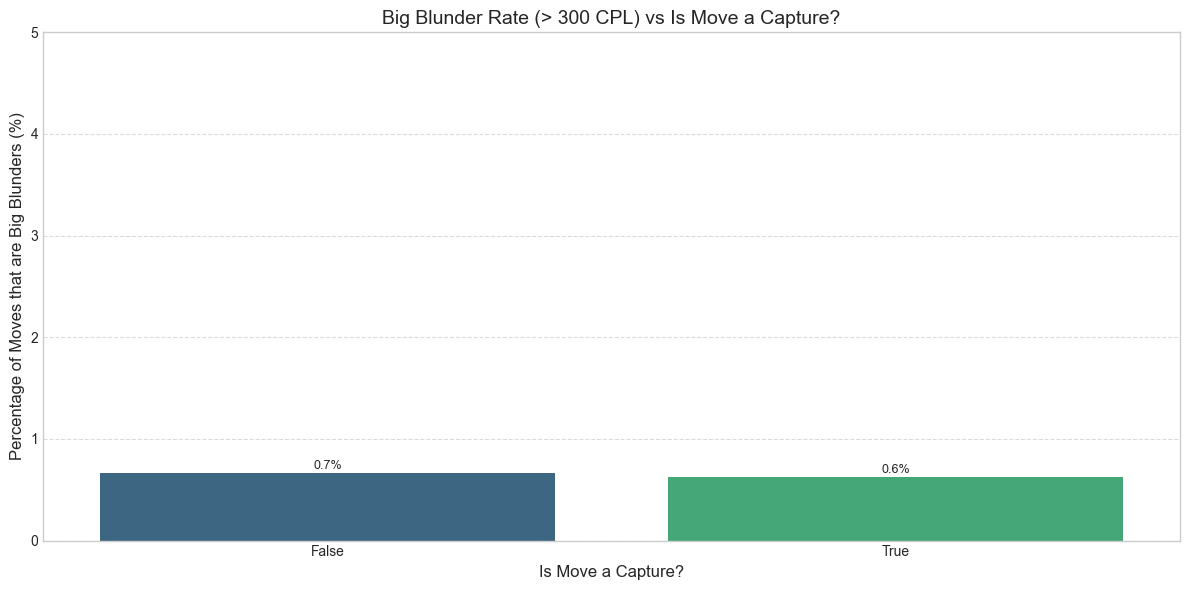

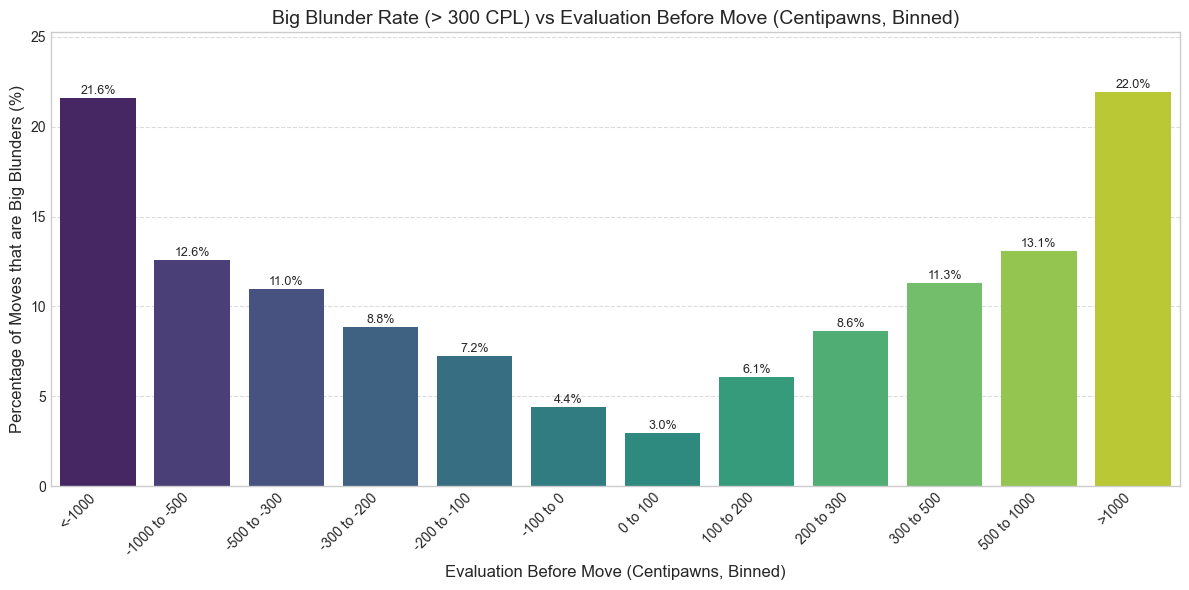

In [130]:
# Analysis 4 - Blunder Rate vs. Key Factors

if not df_moves.empty:
    print("\n--- Analysis 4: Blunder Rate vs. Key Factors ---")
    # Define a function to plot Blunder Rate vs a factor
    def plot_blunder_rate(df, factor_col, factor_label, **kwargs):
        if factor_col not in df.columns or 'IsBigBlunder' not in df.columns:
            print(f"Skipping plot: Column '{factor_col}' or 'IsBigBlunder' not found.")
            return

        # Drop rows where the factor is NaN
        plot_data = df.dropna(subset=[factor_col])

        # Group by factor and calculate mean of IsBigBlunder (which is the rate)
        agg_data = plot_data.groupby(factor_col, observed=False).agg(
            BlunderRate=('IsBigBlunder', 'mean'),
            MoveCount=('IsBigBlunder', 'count')
        ).reset_index()
        agg_data['BlunderRate'] *= 100 # Convert to percentage

        if agg_data.empty:
            print(f"Skipping plot for {factor_label}: No data after aggregation.")
            return

        plt.figure(figsize=(12, 6))
        ax = sns.barplot(data=agg_data, x=factor_col, y='BlunderRate', palette=plot_palette, **kwargs)

        # Add percentage labels on bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0: # Avoid labeling zero bars
                ax.annotate(f'{height:.1f}%',
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center',
                            xytext=(0, 5), # 5 points vertical offset
                            textcoords='offset points', fontsize=9)

        plt.title(f'Big Blunder Rate (> {BLUNDER_THRESHOLD_CP} CPL) vs {factor_label}', fontsize=14)
        plt.xlabel(factor_label, fontsize=12)
        plt.ylabel('Percentage of Moves that are Big Blunders (%)', fontsize=12)
        plt.ylim(0, max(agg_data['BlunderRate'].max() * 1.15, 5)) # Dynamic Y limit, ensure at least 5% is visible
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if df[factor_col].dtype == 'category' or df[factor_col].nunique() > 10 :
             plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # --- Generate Plots ---
    # vs. Player ELO (Tight Bins)
    plot_blunder_rate(df_moves, 'EloBinTight', 'Player ELO (100 ELO Bins)')

    # vs. Time Spent (Binned, use filtered df)
    plot_blunder_rate(df_moves_filtered_time, 'TimeSpentBin', 'Time Spent per Move (Binned)')

    # vs. Remaining Clock Time (Binned) - FILTERED FOR MIDDLEGAME
    print("\nPlotting: Blunder Rate vs Clock Time (Middlegame Only)")
    # Ensure GamePhase column exists and filter for Middlegame
    if 'GamePhase' in df_moves.columns:
        # Filter the DataFrame for middlegame moves
        df_moves_middlegame_blunder = df_moves[df_moves['GamePhase'] == 'Middlegame'].copy()
        if not df_moves_middlegame_blunder.empty and 'ClockTimeBin' in df_moves_middlegame_blunder.columns:
            # Plot using the filtered DataFrame
            plot_blunder_rate(df_moves_middlegame_blunder,
                              'ClockTimeBin',
                              'Clock Time Before Move (Binned, Middlegame Only)')
        elif 'ClockTimeBin' not in df_moves.columns:
             print("Skipping Blunder Rate vs Clock Time (Middlegame) - 'ClockTimeBin' column missing.")
        else:
            print("Skipping Blunder Rate vs Clock Time (Middlegame) - No middlegame data found.")
    else:
        print("Skipping Blunder Rate vs Clock Time (Middlegame) - 'GamePhase' column not found.")

    # vs. Game Phase
    plot_blunder_rate(df_moves, 'GamePhase', 'Game Phase', order=['Opening', 'Middlegame', 'Endgame'])

    # vs. Number of Legal Moves (Binned)
    plot_blunder_rate(df_moves, 'LegalMovesBin', 'Number of Legal Moves (Binned)')

    # vs. Is Check Before Move
    plot_blunder_rate(df_moves, 'IsCheck_BeforeMove', 'Is Player in Check Before Move?')

    # vs. Is Capture
    plot_blunder_rate(df_moves, 'IsCapture', 'Is Move a Capture?')

    # vs. Material Balance (Binned)
    if 'MaterialBin' in df_moves.columns:
        plot_blunder_rate(df_moves, 'MaterialBin', 'Player Material Balance (Binned)')

    # vs. Evaluation Before Move (Binned)
    if 'EvalBin' in df_moves.columns:
        plot_blunder_rate(df_moves, 'EvalBin', 'Evaluation Before Move (Centipawns, Binned)')

else:
    print("Skipping Analysis 4 - Data not loaded.")


--- Analysis 5: Interactive Effects (Examples) ---
Plotting: Avg CPLoss vs Time Spent, Faceted by ELO Bin


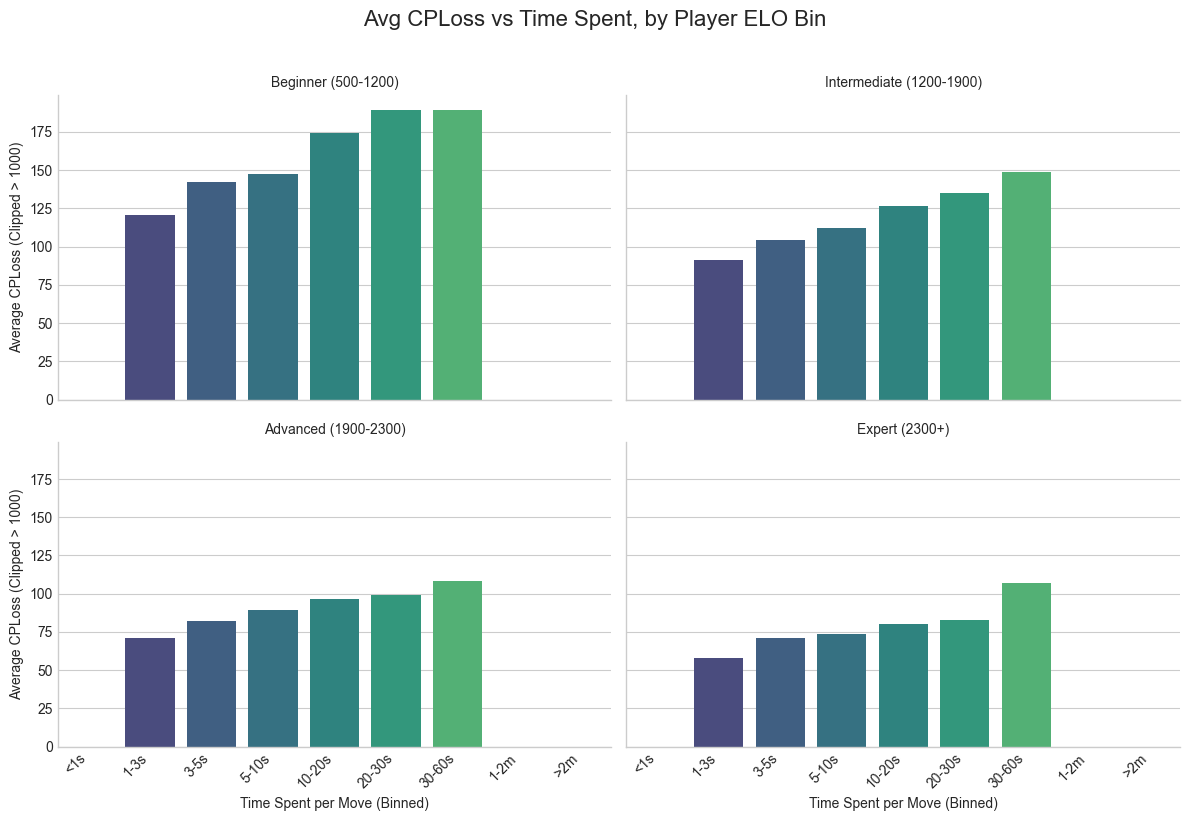


Plotting: Blunder Rate vs Clock Time, Colored by ELO Bin (Middlegame Only)


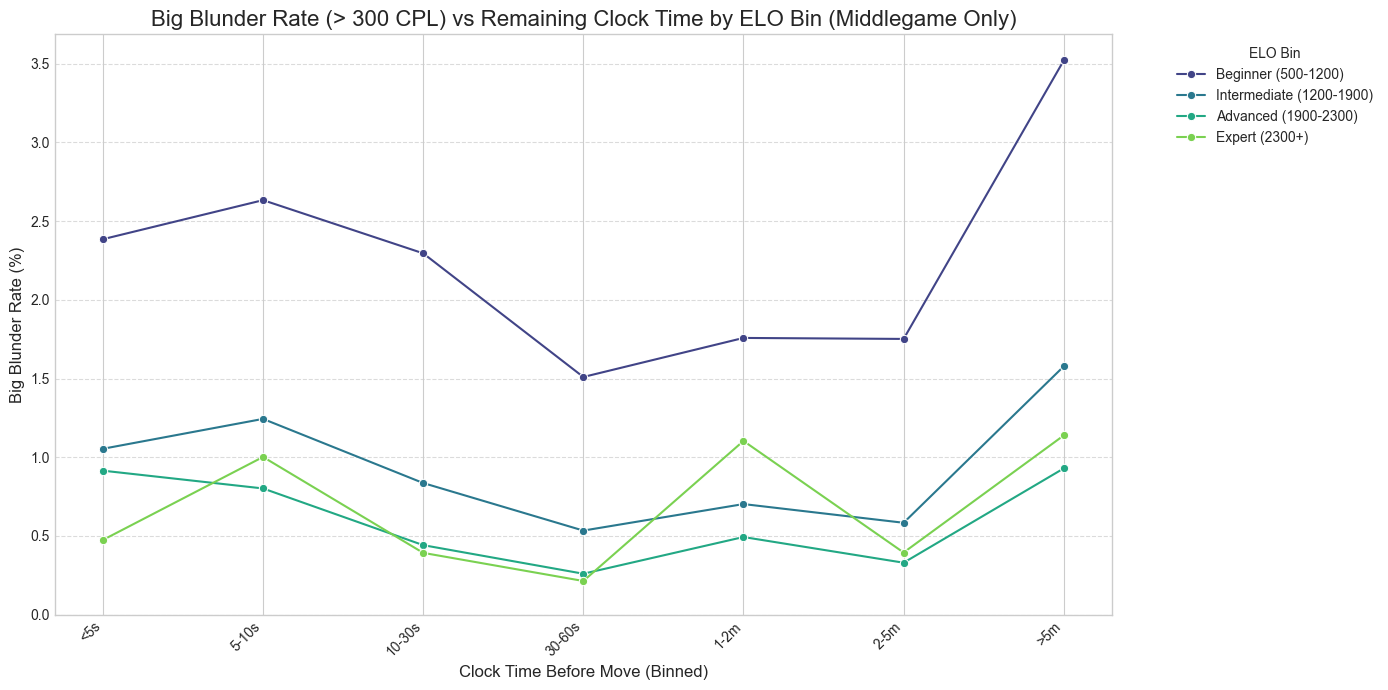


Plotting: CPLoss Distribution by Game Phase, Faceted by ELO Bin


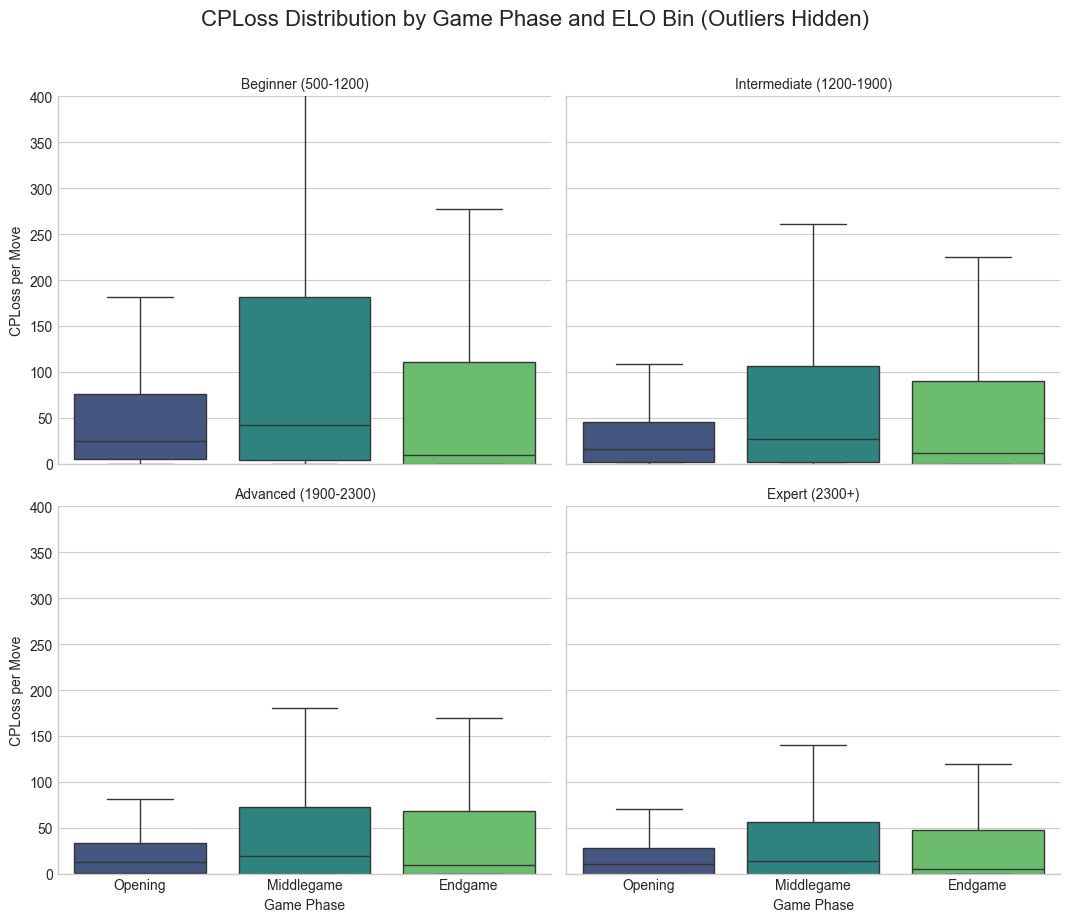

In [131]:
# Analysis 5 - Interactive Effects (Examples using Faceting/Hue)

if not df_moves.empty and not df_moves_filtered_time.empty:
    print("\n--- Analysis 5: Interactive Effects (Examples) ---")

    # Example 1: Avg CPLoss vs Time Spent, Faceted by ELO Bin
    print("Plotting: Avg CPLoss vs Time Spent, Faceted by ELO Bin")
    if 'TimeSpentBin' in df_moves_filtered_time.columns and 'EloBin' in df_moves_filtered_time.columns:
        plot_data_ex1 = df_moves_filtered_time.dropna(subset=['TimeSpentBin', 'EloBin', 'CPLoss'])
        agg_data_ex1 = plot_data_ex1.groupby(['EloBin', 'TimeSpentBin'], observed=False).agg(
            Avg_CPLoss=('CPLoss', lambda x: x.clip(upper=CPLOSS_CLIP_FOR_AVG).mean())
        ).reset_index()

        if not agg_data_ex1.empty:
            g = sns.FacetGrid(agg_data_ex1, col="EloBin", col_wrap=2, height=4, aspect=1.5, col_order=elo_labels, sharey=True)
            g.map(sns.barplot, "TimeSpentBin", "Avg_CPLoss", palette=plot_palette, order=time_labels) # Use barplot as TimeSpent is binned
            g.set_axis_labels("Time Spent per Move (Binned)", f"Average CPLoss (Clipped > {CPLOSS_CLIP_FOR_AVG})")
            g.set_titles("{col_name}")
            g.fig.suptitle(f'Avg CPLoss vs Time Spent, by Player ELO Bin', y=1.02, fontsize=16)
            # Rotate x-labels on each subplot
            for ax in g.axes.flat:
                 plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            g.tight_layout()
            plt.show()
        else: print("Skipping Example 1 - No data after aggregation.")
    else: print("Skipping Example 1 - Required columns missing.")


# Example 2: Blunder Rate vs Clock Time Remaining, Colored by ELO Bin - FILTERED FOR MIDDLEGAME
    print("\nPlotting: Blunder Rate vs Clock Time, Colored by ELO Bin (Middlegame Only)")
    # Ensure required columns exist
    required_cols_ex2 = ['GamePhase', 'ClockTimeBin', 'EloBin', 'IsBigBlunder']
    if all(col in df_moves.columns for col in required_cols_ex2):
        # Filter for Middlegame first
        df_moves_middlegame_ex2 = df_moves[df_moves['GamePhase'] == 'Middlegame'].copy()

        if not df_moves_middlegame_ex2.empty:
            # Now drop NaNs from the filtered data for the columns needed in aggregation/plotting
            plot_data_ex2 = df_moves_middlegame_ex2.dropna(subset=['ClockTimeBin', 'EloBin', 'IsBigBlunder'])

            if not plot_data_ex2.empty:
                # Proceed with aggregation
                agg_data_ex2 = plot_data_ex2.groupby(['EloBin', 'ClockTimeBin'], observed=False).agg(
                    BlunderRate=('IsBigBlunder', 'mean')
                ).reset_index()
                agg_data_ex2['BlunderRate'] *= 100 # Percentage

                if not agg_data_ex2.empty:
                    # --- Plotting ---
                    plt.figure(figsize=(14, 7))
                    sns.lineplot(data=agg_data_ex2, x='ClockTimeBin', y='BlunderRate', hue='EloBin',
                                 marker='o', hue_order=elo_labels, palette=plot_palette)
                    # Update title to reflect filter
                    plt.title(f'Big Blunder Rate (> {BLUNDER_THRESHOLD_CP} CPL) vs Remaining Clock Time by ELO Bin (Middlegame Only)', fontsize=16)
                    plt.xlabel('Clock Time Before Move (Binned)', fontsize=12)
                    plt.ylabel('Big Blunder Rate (%)', fontsize=12)
                    plt.legend(title='ELO Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.xticks(rotation=45, ha='right')
                    plt.grid(axis='y', linestyle='--', alpha=0.7)
                    plt.ylim(bottom=0)
                    plt.tight_layout()
                    plt.show()
                else: print("Skipping Example 2 (Middlegame) - No data after aggregation.")
            else: print("Skipping Example 2 (Middlegame) - No non-NaN data after filtering for middlegame.")
        else: print("Skipping Example 2 (Middlegame) - No middlegame moves found.")
    else:
        missing = [col for col in required_cols_ex2 if col not in df_moves.columns]
        print(f"Skipping Example 2 (Middlegame) - Required columns missing: {missing}")

    # Example 3: CPLoss Distribution by Game Phase, Faceted by ELO Bin (Box Plot)
    print("\nPlotting: CPLoss Distribution by Game Phase, Faceted by ELO Bin")
    if 'GamePhase' in df_moves.columns and 'EloBin' in df_moves.columns:
         # Ensure GamePhase has the correct order
        df_moves['GamePhase'] = pd.Categorical(df_moves['GamePhase'], categories=['Opening', 'Middlegame', 'Endgame'], ordered=True)

        plot_data_ex3 = df_moves.dropna(subset=['GamePhase', 'EloBin', 'CPLoss'])

        if not plot_data_ex3.empty:
            g = sns.FacetGrid(plot_data_ex3, col="EloBin", col_wrap=2, height=4.5, aspect=1.2, col_order=elo_labels, sharey=True)
            g.map(sns.boxplot, "GamePhase", "CPLoss", palette=plot_palette, showfliers=False, order=['Opening', 'Middlegame', 'Endgame'])
            g.set_axis_labels("Game Phase", "CPLoss per Move")
            g.set(ylim=CPLOSS_YLIM_BOX) # Apply consistent Y limit
            g.set_titles("{col_name}")
            g.fig.suptitle('CPLoss Distribution by Game Phase and ELO Bin (Outliers Hidden)', y=1.02, fontsize=16)
            g.tight_layout()
            plt.show()
        else: print("Skipping Example 3 - No data after aggregation.")
    else: print("Skipping Example 3 - Required columns missing.")


else:
    print("Skipping Analysis 5 - Data not loaded or filtered data empty.")